In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Incorporating Exogenous Controls to our ARIMA baseline model

We now include the monthly sentiment scores and topics scores into our baseline ARIMA model as exogenous, same month controls. In doing this, we study whether this simple approach improves predictive scores.

We first restate the stationarity tests and optimal ARIMA parameters for the CCI. We do this because we want to corroborate that the conclusions reached in the ARIMA baseline Notebook still apply to this more restricted period starting in January, 1990.

We then proceed to include the SentiWordNet (SWN) sentiment scores for the first 15 days of a given month, with which we obtain out of sample prediction scores. We use only the first 15 days of data per month to test whether we can capture predictive value with news data over two weeks before the release of new CCI scores. 

Finally, we add the 8 topics scores from the LDA decomposition and capture the new model's predictive capacity.

## Summary:
- Our best model for predicting CCI with restricted data starting in 1990 is still AR(2), MA(3) and I(1).
- The in-sample R$^2$ of this model is 99%
- The Roll-forward R$^2$ of this model on the last year of CCI data is 39.5%
- The ARIMA model with current SWN scores as exogenous control improves on the roll-forward predictions on the last year of CCI data (R$^2$ = 42.4%).
- Including LDA topics does not improve on in-sample or roll-forward predictions. 

## 1) Reassessing CCI data starting on 1990

In [18]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
df = pd.read_csv('Economic_Sentiment_Forecast/CCI.csv', parse_dates=True, index_col='TIME',date_parser=dateparse)
df = df["Value"]
df.columns = ["value"]
df = df['1990-01-01':]

### Visualize restricted CCI data and test stationarity

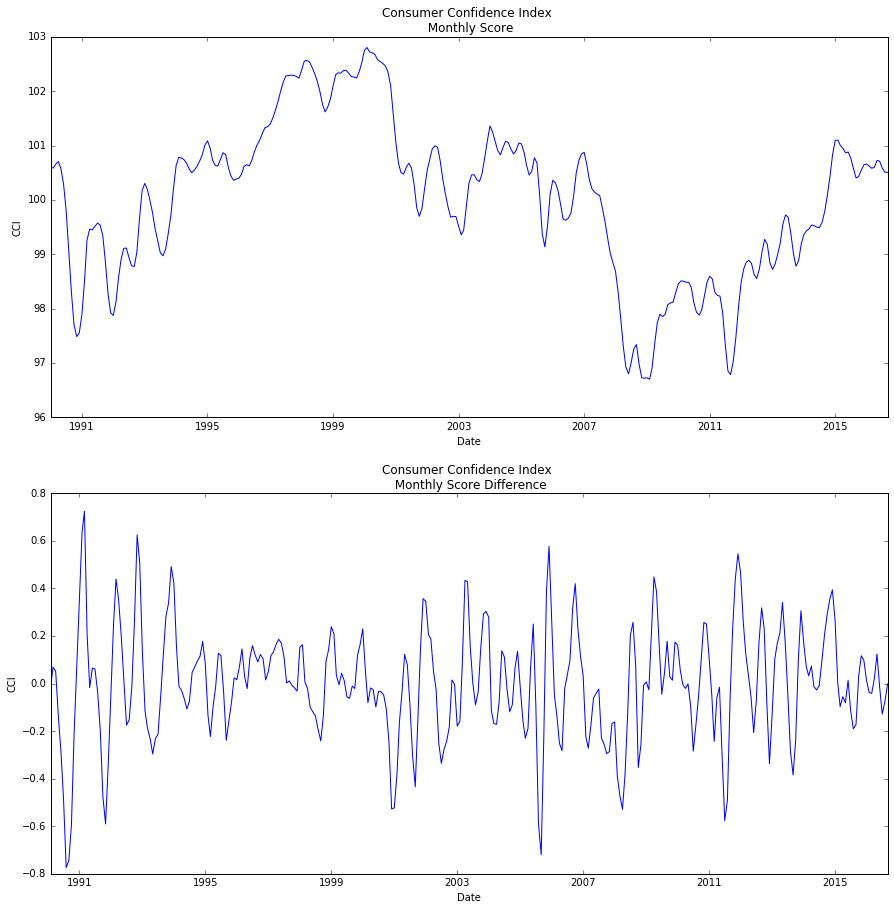

In [19]:
fig = plt.figure(figsize = (15, 15))

ax1 = fig.add_subplot(2, 1, 1)
ax1 = plt.plot(df)
ax1 = plt.title('Consumer Confidence Index \n Monthly Score')
ax1 = plt.xlabel('Date')
ax1 = plt.ylabel('CCI')

ax1 = fig.add_subplot(2, 1, 2)
ax1 = plt.plot(df.diff())
ax1 = plt.title('Consumer Confidence Index \n Monthly Score Difference')
ax1 = plt.xlabel('Date')
ax1 = plt.ylabel('CCI')

plt.show()

In [20]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig, ax = plt.subplots(1,1, figsize=(20, 5))
    ax = plt.plot(timeseries, color='blue',label='Original')
    ax = plt.plot(rolmean, color='red', label='Rolling Mean')
    #ax = plt.plot(rolstd, color='black', label = 'Rolling Std')
    #ax = plt.plot(timeseries-rolmean, color='green', label = 'Noise')
    ax = plt.legend(loc='best')
    ax = plt.title('CCI and its Rolling Mean')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    for j in ['nc', 'c', 'ct']:
        print ''
        print 'Results of Dickey-Fuller Test (Reg. {}):'.format(j)
        dftest = tsa.adfuller(timeseries, autolag='AIC', regression = j)
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print dfoutput

In [21]:
def is_unit_root(data, threshold="5%"):
    
    nc = tsa.adfuller(data, regression="nc")
    c = tsa.adfuller(data, regression="c")
    ct = tsa.adfuller(data, regression="ct")
    
    votes = 0
    for test in [nc, c, ct]:
        if(abs(test[0]) < abs(test[4][threshold])):
            votes += 1
            
    return votes >= 2, {"nc": nc, "c":c, "ct":ct}

Stationarity Tests for restricted CCI series: 


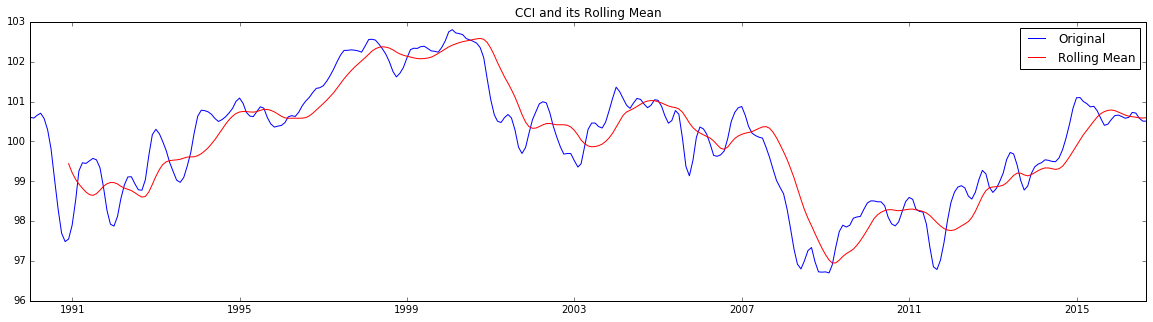


Results of Dickey-Fuller Test (Reg. nc):
Test Statistic                   0.025928
p-value                          0.692838
#Lags Used                       4.000000
Number of Observations Used    316.000000
Critical Value (5%)             -1.941883
Critical Value (1%)             -2.572852
Critical Value (10%)            -1.616006
dtype: float64

Results of Dickey-Fuller Test (Reg. c):
Test Statistic                  -1.990305
p-value                          0.290840
#Lags Used                       4.000000
Number of Observations Used    316.000000
Critical Value (5%)             -2.870730
Critical Value (1%)             -3.451215
Critical Value (10%)            -2.571666
dtype: float64

Results of Dickey-Fuller Test (Reg. ct):
Test Statistic                  -2.007007
p-value                          0.597612
#Lags Used                       4.000000
Number of Observations Used    316.000000
Critical Value (5%)             -3.424476
Critical Value (1%)             -3.987708
Criti

In [22]:
print 'Stationarity Tests for restricted CCI series: '
test_stationarity(df)

Now again, we cannot reject the null hypothesis of a random walk on the CCI series starting on 1990.

### Test stationary condition on the first difference of CCI

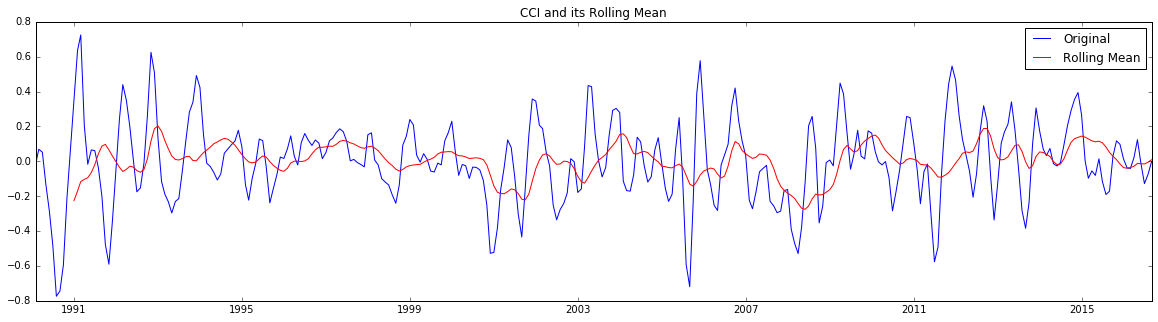


Results of Dickey-Fuller Test (Reg. nc):
Test Statistic                -8.707714e+00
p-value                        7.953037e-15
#Lags Used                     3.000000e+00
Number of Observations Used    3.160000e+02
Critical Value (5%)           -1.941883e+00
Critical Value (1%)           -2.572852e+00
Critical Value (10%)          -1.616006e+00
dtype: float64

Results of Dickey-Fuller Test (Reg. c):
Test Statistic                -8.693726e+00
p-value                        3.976558e-14
#Lags Used                     3.000000e+00
Number of Observations Used    3.160000e+02
Critical Value (5%)           -2.870730e+00
Critical Value (1%)           -3.451215e+00
Critical Value (10%)          -2.571666e+00
dtype: float64

Results of Dickey-Fuller Test (Reg. ct):
Test Statistic                -8.683417e+00
p-value                        1.904969e-12
#Lags Used                     3.000000e+00
Number of Observations Used    3.160000e+02
Critical Value (5%)           -3.424476e+00
Critical 

In [23]:
diff = df.diff()
diff.dropna(inplace=True)
test_stationarity(diff)

We can confidently reject the null hypothesis that the first differences of the CCI series starting on 1990 behave like a random walk. 

### Define parameters of the ARIMA model for the CCI starting in 1990

In [24]:
from statsmodels.tsa.stattools import acf, pacf
diff_acf = acf(diff, nlags = 20)
diff_pacf = pacf(diff, nlags = 20, method = 'ols')

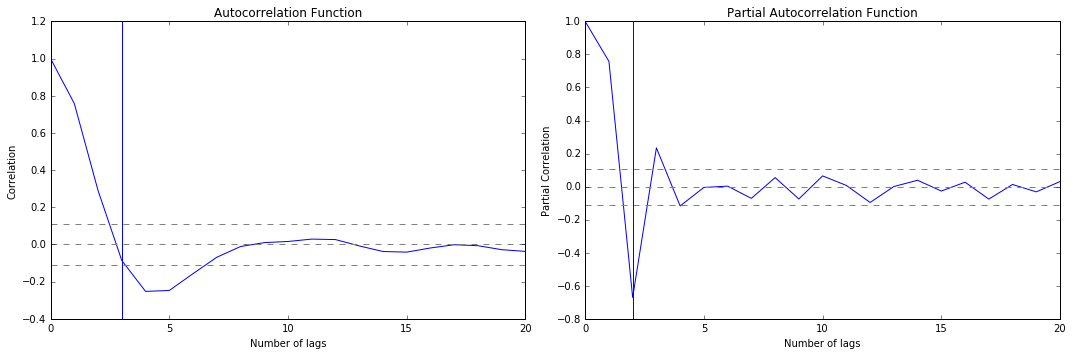

In [25]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(diff_acf)
plt.xlabel('Number of lags')
plt.ylabel('Correlation')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.axvline(3)

plt.subplot(122)
plt.plot(diff_pacf)
plt.xlabel('Number of lags')
plt.ylabel('Partial Correlation')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.axvline(2)

plt.tight_layout()
plt.show()

The optimal parameters from the ACF-PACF heuristic are the same as with the 1960 series.

In [26]:
AICs = []
BICs = []
MLs = []
Ss = []
HQICs = []
Ns = []
for i in range(12):
    model = tsa.ARIMA(df, order=(i+1, 1, 3))
    results = model.fit(disp=-1)
    AICs.append(results.aic)
    BICs.append(results.bic)
    MLs.append(results.llf)
    HQICs.append(results.hqic)
    Ss.append(sum((results.fittedvalues-diff)**2))
    Ns.append(i+1)

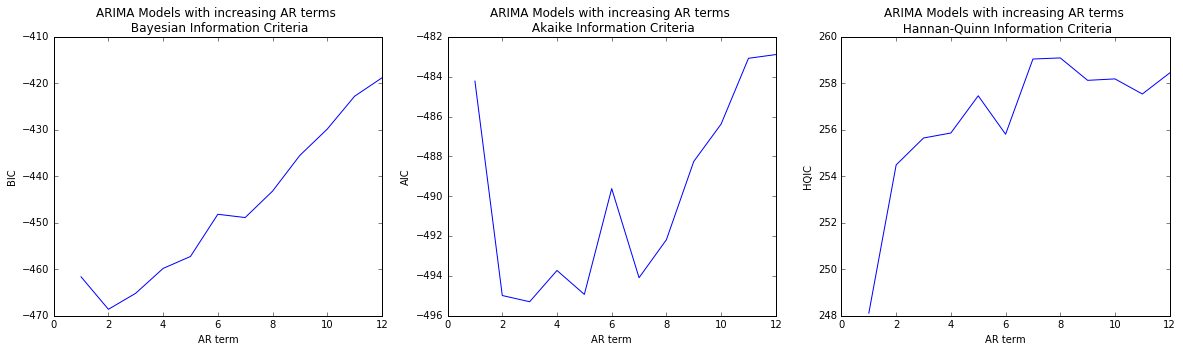

In [27]:
fig = plt.figure(figsize = (20, 5))

ax1 = fig.add_subplot(1, 3, 1)
ax1 = plt.plot(Ns, BICs)
ax1 = plt.title('ARIMA Models with increasing AR terms \n Bayesian Information Criteria')
ax1 = plt.ylabel('BIC')
ax1 = plt.xlabel('AR term')

ax2 = fig.add_subplot(1, 3, 2)
ax2 = plt.plot(Ns, AICs)
ax2 = plt.title('ARIMA Models with increasing AR terms \n Akaike Information Criteria')
ax2 = plt.ylabel('AIC')
ax2 = plt.xlabel('AR term')

ax3 = fig.add_subplot(1, 3, 3)
ax3 = plt.plot(Ns, MLs)
ax3 = plt.title('ARIMA Models with increasing AR terms \n Hannan-Quinn Information Criteria')
ax3 = plt.ylabel('HQIC')
ax3 = plt.xlabel('AR term')

plt.show()

With these results, we are even more confident of using an AR(2) term for our baseline ARIMA estimations.

ARIMA in-sample predictions:


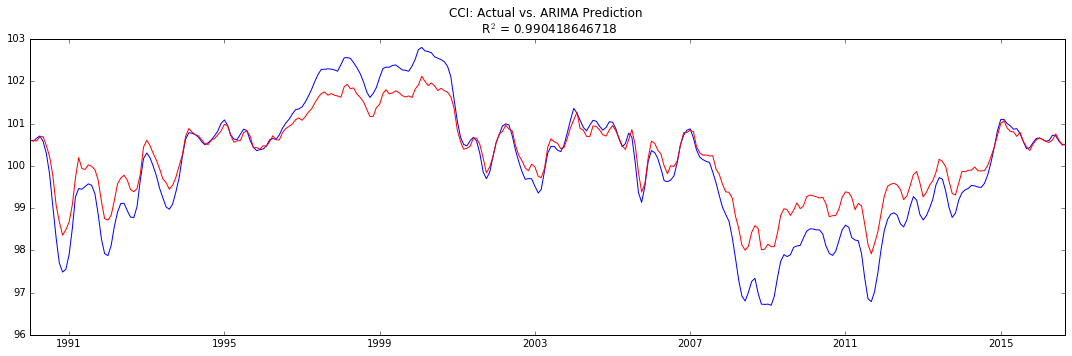

In [29]:
# In Sample Predictions
model_ARIMA = tsa.ARIMA(df, order=(2, 1, 3))
results_ARIMA = model_ARIMA.fit(disp=-1)

raw_preds = pd.Series(results_ARIMA.fittedvalues, copy= True)
sum_preds = raw_preds.cumsum()
pred = pd.Series(df.ix[0], index=df.index)
pred = pred.add(sum_preds, fill_value=0)
from sklearn.linear_model import LinearRegression as LR
x = np.asarray(pred).reshape(len(df), 1)
y = np.asarray(df).reshape(len(df), 1)
lr = LR().fit(x, y)
a = lr.score(x, y)

print 'ARIMA in-sample predictions:'
plt.figure(figsize = (15,5))
plt.plot(df)
plt.plot(pred, color = 'r')
plt.title('CCI: Actual vs. ARIMA Prediction \n R$^2$ = {}'.format(a))
plt.tight_layout()
plt.show()

ARIMA Roll-Forward Predictions for the last year of data: 


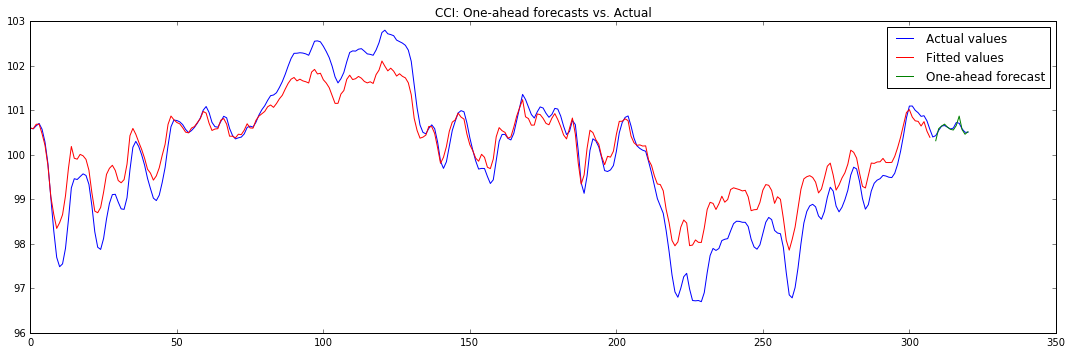

'R2 score for Roll-Forward predictions for the last 12 months: 0.395'

In [30]:
print 'ARIMA Roll-Forward Predictions for the last year of data: '
futureRange = 12
model_ARIMA = tsa.ARIMA(df.iloc[:-futureRange], order=(2, 1, 3))
results_ARIMA = model_ARIMA.fit(disp=-1)
raw_preds = pd.Series(results_ARIMA.fittedvalues, copy= True)
sum_preds = raw_preds.cumsum()
pred = sum_preds + df.ix[0]
allFuture = np.zeros(futureRange)

for i in range(futureRange):
    model_ARIMA = tsa.ARIMA(df.iloc[:-futureRange+i], order=(2, 1, 3))
    results_ARIMA = model_ARIMA.fit(disp=-1, maxiter=100)
    allFuture[i] = results_ARIMA.forecast(steps=1)[0]

plt.figure(figsize = (15,5))
plt.plot(df.values, label='Actual values')
plt.plot(pred.values, color='red', label='Fitted values')
plt.plot(np.concatenate((np.full(len(df)-futureRange,np.nan),allFuture)), color='green', label='One-ahead forecast')
plt.title('CCI: One-ahead forecasts vs. Actual')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

'R2 score for Roll-Forward predictions for the last 12 months: {:.3f}'.format(r2_score(df.iloc[-futureRange:].values, allFuture))

We see that working with data from 1990 to 2016, our ARIMA model improves both in-sample and out of sample predictions from 98.5% to 99% and from 36% to 40% respectively. We will use the latter two scores for benchmarking purposes.

## 2) Including SentiWordNet (SWN) Data into the model as exogenous, same month control.

In [31]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df2 = pd.read_csv('./AC209_Project_data/daily_sentiment_1990_2016.csv', parse_dates=True, index_col='date',date_parser=dateparse)
df2 = df2[["avg_score"]]
df2.columns = ["value"]
df2 = df2[df2.index.day < 15].resample('MS').mean()

As discussed above, we are loading the first 15 days of data of each month in order to study whether improved predictions can be produced with SWN data available over 2 weeks before the release of CCI scores.

### Test stationarity of the SWN series

Stationarity Tests for SWN series: 


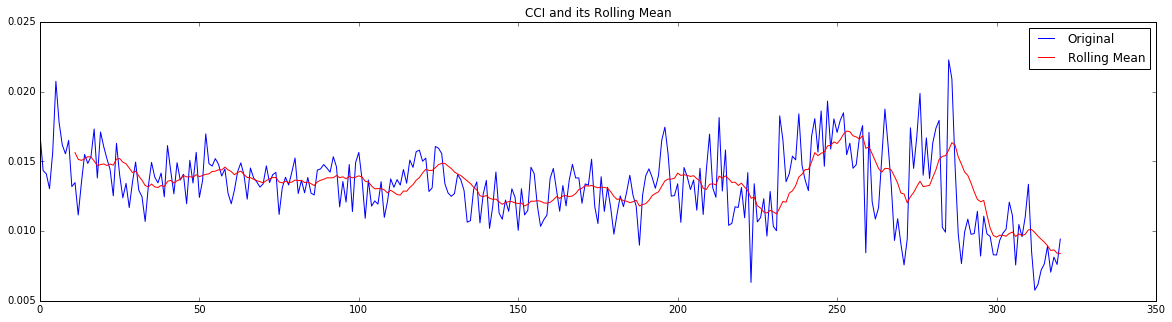


Results of Dickey-Fuller Test (Reg. nc):
Test Statistic                  -0.826694
p-value                          0.359332
#Lags Used                      13.000000
Number of Observations Used    307.000000
Critical Value (5%)             -1.941910
Critical Value (1%)             -2.573061
Critical Value (10%)            -1.615983
dtype: float64

Results of Dickey-Fuller Test (Reg. c):
Test Statistic                  -3.621826
p-value                          0.005357
#Lags Used                       4.000000
Number of Observations Used    316.000000
Critical Value (5%)             -2.870730
Critical Value (1%)             -3.451215
Critical Value (10%)            -2.571666
dtype: float64

Results of Dickey-Fuller Test (Reg. ct):
Test Statistic                  -3.985404
p-value                          0.009223
#Lags Used                       4.000000
Number of Observations Used    316.000000
Critical Value (5%)             -3.424476
Critical Value (1%)             -3.987708
Criti

In [34]:
print 'Stationarity Tests for SWN series: '
test_stationarity(df2.values.reshape(len(df2),))

The Dickey-Fuller tests suggest that we can confidently reject the null hypothesis that the SWN series follows a random walk. Hence, we include the SWN as control for the ARIMA model in levels.

### Estimate ARIMA model with SWN series as exogenous control.

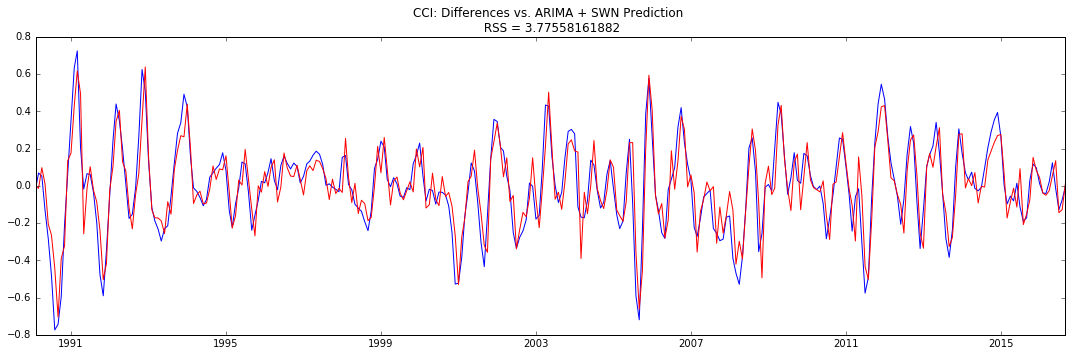

In [36]:
# ARIMA Model
model_ARIMA = tsa.ARIMA(df, order=(2, 1, 3), exog=df2)
results_ARIMA = model_ARIMA.fit(disp=-1)
plt.figure(figsize = (15,5))
plt.plot(diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('CCI: Differences vs. ARIMA + SWN Predictions \n RSS = {}'.format(sum((results_ARIMA.fittedvalues-diff)**2)))
plt.tight_layout()
plt.show()

In [37]:
print 'Results summary for the ARIMA model with exogenous SWN controls: '
results_ARIMA.summary2()

Results summary for the ARIMA model with exogenous SWN controls: 


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            BIC:                 -464.5354 
Dependent Variable: D.Value          Log-Likelihood:      255.34    
Date:               2016-12-13 11:08 Scale:               1.0000    
No. Observations:   320              Method:              css-mle   
Df Model:           7                Sample:              02-01-1990
Df Residuals:       313                                   09-01-2016
Converged:          1.0000           S.D. of innovations: 0.109     
AIC:                -494.6820        HQIC:                -482.644  
---------------------------------------------------------------------
                  Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const            -0.0302    0.0283  -1.0657  0.2874  -0.0857   0.0253
value             2.2634    1.7288   1.3092  0.1914  -1.1250   5.6518
ar.L1.D.Value     1.2035    0.1294   9.3023  0.0000   0.9499   1.4570
ar.L2.D.Value    -0.5080    0.0720  -7.0523  0.0000  -0.6491  -0.3668
ma.L1.D.Value     0.2570    0.1379   1.8636  0.0633  -0.0133   0.5273
ma.L2.D.Value    -0.2261    0.1748  -1.2935  0.1968  -0.5688   0.1165
ma.L3.D.Value    -0.1975    0.1188  -1.6617  0.0976  -0.4304   0.0354
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            1.1846            -0.7519           1.4031            -0.0900
AR.2            1.1846             0.7519           1.4031             0.0900
MA.1            1.6118            -0.0000           1.6118            -0.0000
MA.2           -1.3784            -1.1144           1.7726            -0.3918
MA.3           -1.3784             1.1144           1.7726             0.3918
====================================================================

"""

### Convert predictions back to the original scale of the CCI series and get model scores.

In [38]:
raw_preds = pd.Series(results_ARIMA.fittedvalues, copy= True)
sum_preds = raw_preds.cumsum()
pred = pd.Series(df.ix[0], index=df.index)
pred = pred.add(sum_preds, fill_value=0)

In [39]:
from sklearn.linear_model import LinearRegression as LR
x = np.asarray(pred).reshape(len(df), 1)
y = np.asarray(df).reshape(len(df), 1)
lr = LR().fit(x, y)
a = lr.score(x, y)

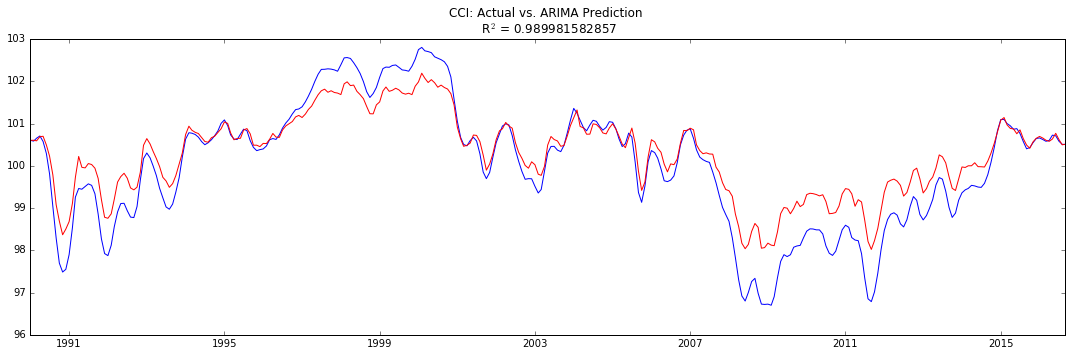

In [40]:
plt.figure(figsize = (15,5))
plt.plot(df)
plt.plot(pred, color = 'r')
plt.title('CCI: Actual vs. ARIMA Prediction \n R$^2$ = {}'.format(a))
plt.tight_layout()
plt.show()

While only slightly lower, we see that including the SWN series does not yield an improvement in the in-sample R2 score of the simple ARIMA model.

### Roll-forward predictions of the ARIMA + SWN model on last year of data.

In [41]:
model_ARIMA = tsa.ARIMA(endog = df.iloc[:-futureRange], order=(2, 1, 3), exog = df2.iloc[:-futureRange])
results_ARIMA = model_ARIMA.fit(disp=-1)
raw_preds = pd.Series(results_ARIMA.fittedvalues, copy= True)
sum_preds = raw_preds.cumsum()
pred = sum_preds + df.ix[0]


allFuture = np.zeros(futureRange)
for i in range(futureRange):
    model_ARIMA = tsa.ARIMA(df.iloc[:-futureRange+i], order=(2, 1, 3), exog = df2.iloc[:-futureRange+i])
    results_ARIMA = model_ARIMA.fit(disp=-1, maxiter=100)
    allFuture[i] = results_ARIMA.forecast(steps=1, exog = pd.Series(data = df2.iloc[-futureRange+i]))[0]

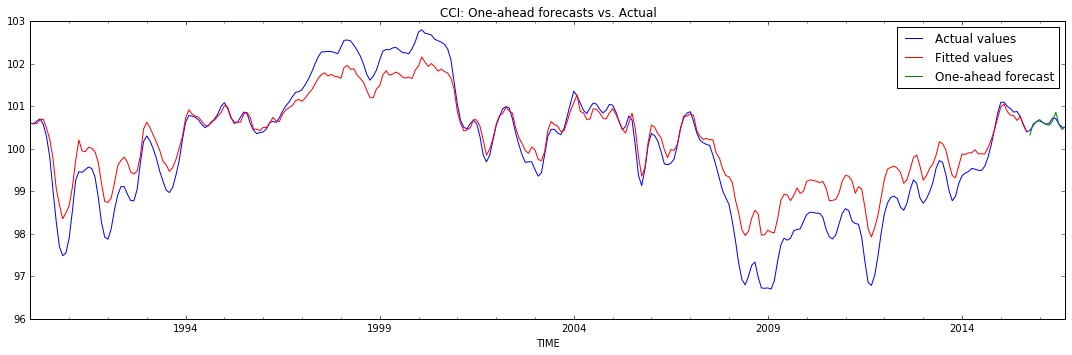

In [42]:
# ARIMA Model

plt.figure(figsize = (15,5))
df.plot(label='Actual values')
pred.plot(color='red', label='Fitted values')
one_ahead = np.concatenate((np.full(len(df)-futureRange,np.nan),allFuture))
one_ahead = pd.Series(one_ahead, index=df.index)
one_ahead.plot(color='green', label='One-ahead forecast')
plt.title('CCI: One-ahead forecasts vs. Actual')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [44]:
'R2 score for Roll-Forward predictions for the last 12 months: {:.3f}'.format(r2_score(df.iloc[-futureRange:].values, allFuture))

'R2 score for Roll-Forward predictions for the last 12 months: 0.424'

Interestingly, the Roll-Forward predictions of the ARIMA + SWN model on the last year of data do improve substatially in contrast with the simple ARIMA model. 

## 3) Including LDA topics data into the model as exogenous, same month controls.

We now attempt to include the topics captured from the LDA decomposition of the New York Times data as same month exogenous controls into the ARIMA + SWN model. As was discussed above, the LDA topics show heavily seasonal dynamics. Below, we visualize the series and two different approaches to deseasonalization.

In [51]:
# Load topics data
top = np.load('topicsByMonthBigrams8.npy')
top = pd.DataFrame(data = top, index = df.index)
top.columns = ['T1','T2','T3','T4','T5','T6','T7','T8']

top1 = np.load('topicsByMonthBigrams8.npy')
top1 = pd.DataFrame(data = top1, index = df.index)
top1.columns = ['T1','T2','T3','T4','T5','T6','T7','T8']
top1 = top1 - top1.shift(12)
top1.dropna(inplace=True)

top2 = np.load('topicsByMonthBigrams8.npy')
top2 = pd.DataFrame(data = top2, index = df.index)
top2.columns = ['T1','T2','T3','T4','T5','T6','T7','T8']

for i in ['T1','T2','T3','T4','T5','T6','T7','T8']: 
    temp1 = tsa.seasonal_decompose(top2[i].values, freq = 12)
    top2[i] = temp1.trend + temp1.resid
top2.dropna(inplace=True)

## Visualize topics and seasonal controls

Topic 1


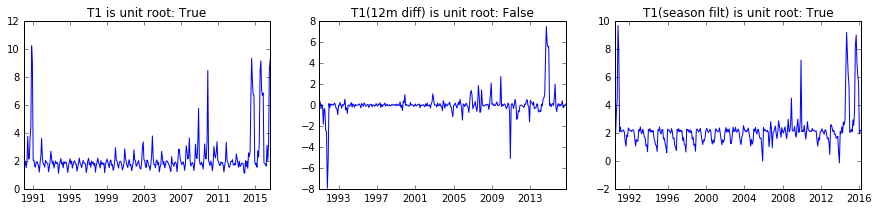

Topic 2


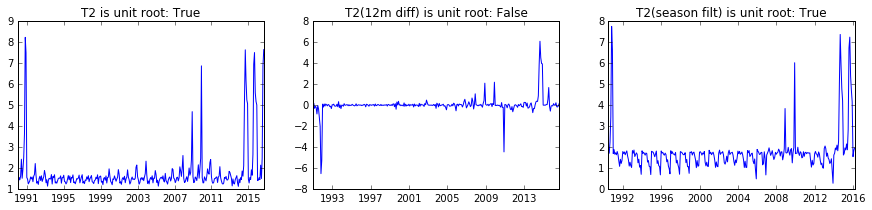

Topic 3


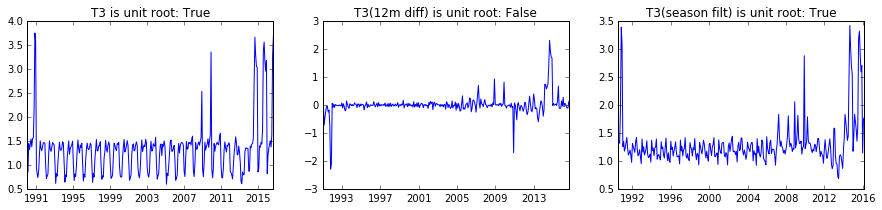

Topic 4


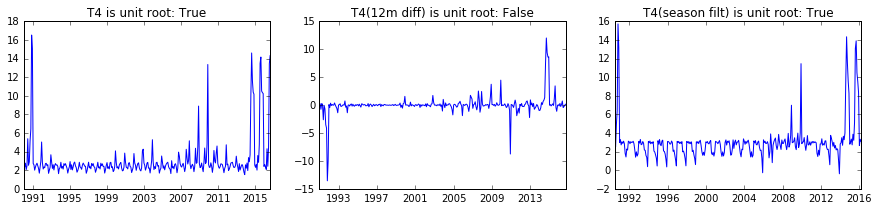

Topic 5


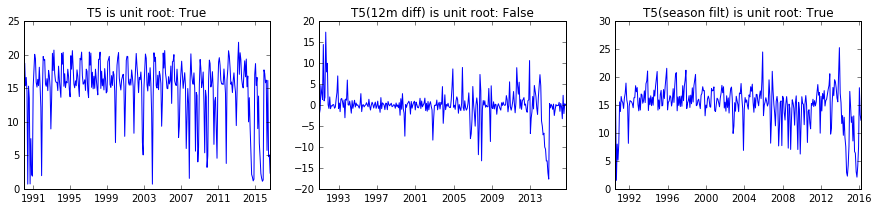

Topic 6


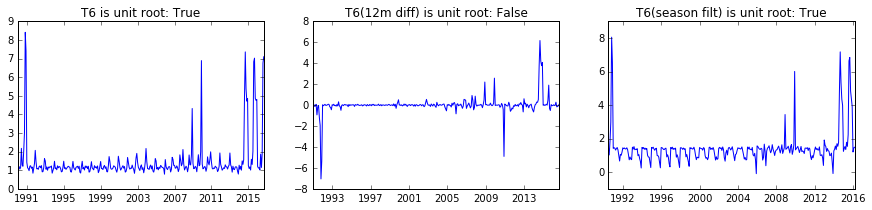

Topic 7


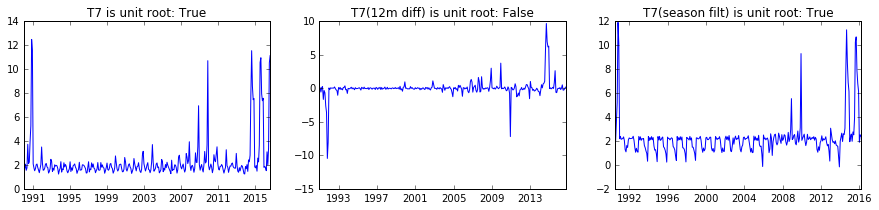

Topic 8


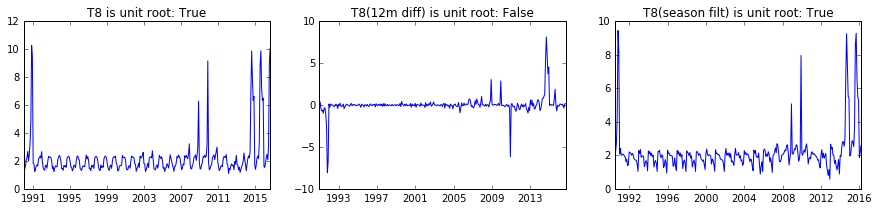

In [54]:
# Visualize topic data
j = 0
for i in ['T1','T2','T3','T4','T5','T6','T7','T8']:
    j = j+1
    print 'Topic {}'.format(j)
    
    a, b = is_unit_root(top[i])
    fig = plt.figure(figsize = (15, 3))
    ax1 = fig.add_subplot(1,3,1)
    ax1 = plt.plot(top[i])
    ax1 = plt.title('{} is unit root: {}'.format(i, a))
   
    
    a, b = is_unit_root(top1[i])
    ax2 = fig.add_subplot(1,3,2)
    ax2 = plt.plot(top1[i])
    ax2 = plt.title('{}(12m diff) is unit root: {}'.format(i, a))
    
    a, b = is_unit_root(top2[i])
    ax3 = fig.add_subplot(1,3,3)
    ax3 = plt.plot(top2[i])
    ax3 = plt.title('{}(season filt) is unit root: {}'.format(i, a))
    
    plt.show()

For all topics, it seems that the 12-month differences are most adequate in dealing with seasonal changes and in making the series stationary. Hence, we will work with these series as exogenous controls of our ARIMA models. 

### Set up ARIMA model with SWN and LDA Topics as exogenous controls

We now build a single dataframe of exogenous controls that includes both the LDA topics and the SWN monthly scores. 

In [57]:
# Load Datasets
exog = pd.concat([df2, top1], axis = 1)
exog.dropna(inplace=True)

df = df['1991-01-01':]
diff = diff['1991-02-01':]

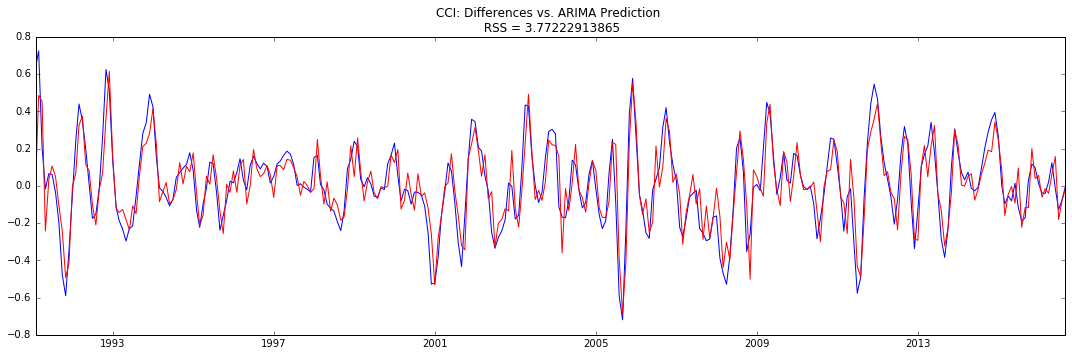

In [58]:
# ARIMA Model
model_ARIMA = tsa.ARIMA(df, order=(2, 1, 3), exog=exog)
results_ARIMA = model_ARIMA.fit(disp=-1)
plt.figure(figsize = (15,5))
plt.plot(diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('CCI: Differences vs. ARIMA Prediction \n RSS = {}'.format(sum((results_ARIMA.fittedvalues-diff)**2)))
plt.tight_layout()
plt.show()

In [59]:
print 'Summary of results of the ARIMA + SWN + LDA Topics: '
results_ARIMA.summary2()

Summary of results of the ARIMA + SWN + LDA Topics: 


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            BIC:                 -416.2054 
Dependent Variable: D.Value          Log-Likelihood:      253.94    
Date:               2016-12-13 11:27 Scale:               1.0000    
No. Observations:   308              Method:              css-mle   
Df Model:           15               Sample:              02-01-1991
Df Residuals:       293                                   09-01-2016
Converged:          0.0000           S.D. of innovations: 0.106     
AIC:                -475.8870        HQIC:                -452.023  
---------------------------------------------------------------------
                  Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const            -0.0168    0.0305  -0.5532  0.5805  -0.0765   0.0428
value             1.6197    1.7543   0.9233  0.3566  -1.8187   5.0580
T1                0.0159    0.0315   0.5039  0.6147  -0.0458   0.0776
T2               -0.0506    0.0306  -1.6534  0.0993  -0.1105   0.0094
T3               -0.0215    0.0338  -0.6380  0.5240  -0.0877   0.0446
T4                0.0048    0.0226   0.2119  0.8323  -0.0395   0.0491
T5                0.0022    0.0024   0.9360  0.3500  -0.0024   0.0069
T6               -0.0116    0.0413  -0.2802  0.7795  -0.0925   0.0694
T7               -0.0067    0.0297  -0.2266  0.8209  -0.0650   0.0515
T8                0.0477    0.0165   2.8900  0.0041   0.0154   0.0801
ar.L1.D.Value     0.7376    0.3691   1.9986  0.0466   0.0143   1.4609
ar.L2.D.Value    -0.3909    0.1758  -2.2236  0.0269  -0.7354  -0.0464
ma.L1.D.Value     0.7410    0.3705   1.9999  0.0464   0.0148   1.4672
ma.L2.D.Value     0.3275    0.3976   0.8236  0.4108  -0.4518   1.1068
ma.L3.D.Value     0.0889    0.1824   0.4874  0.6263  -0.2686   0.4465
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            0.9435            -1.2915           1.5994            -0.1496
AR.2            0.9435             1.2915           1.5994             0.1496
MA.1           -2.2133            -0.0000           2.2133            -0.5000
MA.2           -0.7348            -2.1311           2.2542            -0.3028
MA.3           -0.7348             2.1311           2.2542             0.3028
====================================================================

"""

### Converting predictions back in to the original CCI scale

In [60]:
raw_preds = pd.Series(results_ARIMA.fittedvalues, copy= True)
sum_preds = raw_preds.cumsum()
pred = pd.Series(df.ix[0], index=df.index)
pred = pred.add(sum_preds, fill_value=0)

In [61]:
from sklearn.linear_model import LinearRegression as LR
x = np.asarray(pred).reshape(len(df), 1)
y = np.asarray(df).reshape(len(df), 1)
lr = LR().fit(x, y)
a = lr.score(x, y)

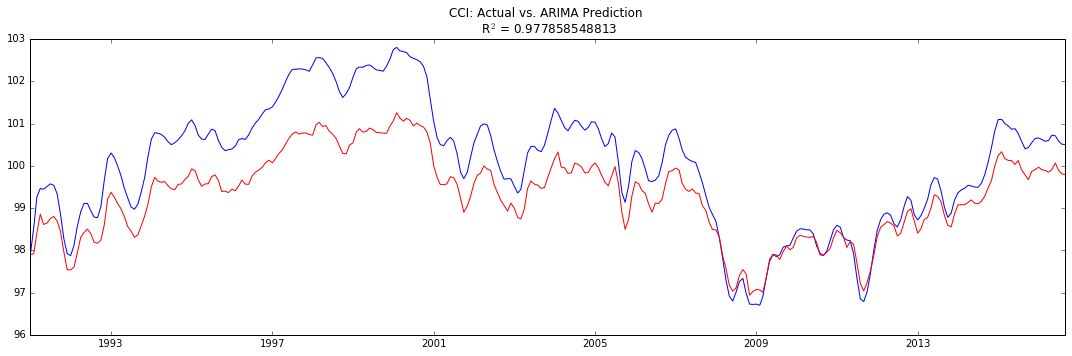

In [62]:
plt.figure(figsize = (15,5))
plt.plot(df)
plt.plot(pred, color = 'r')
plt.title('CCI: Actual vs. ARIMA Prediction \n R$^2$ = {}'.format(a))
plt.tight_layout()
plt.show()

In sample, the expanded model seems to produce worse scores in contrast with those of the simple ARIMA and the ARIMA + SWN models. 

### Roll-forward predictions of the ARIMA + SWN + LDA Topics model on last year of data.

In [65]:
model_ARIMA = tsa.ARIMA(endog = df.iloc[:-futureRange], order=(2, 1, 3), exog = exog.iloc[:-futureRange,:])
results_ARIMA = model_ARIMA.fit(disp=-1)
raw_preds = pd.Series(results_ARIMA.fittedvalues, copy= True)
sum_preds = raw_preds.cumsum()
pred = sum_preds + df.ix[0]


allFuture = np.zeros(futureRange)
for i in range(futureRange):
    model_ARIMA = tsa.ARIMA(df.iloc[:-futureRange+i], order=(2, 1, 3), exog = exog.iloc[:-futureRange+i])
    results_ARIMA = model_ARIMA.fit(disp=-1, maxiter=100)
    allFuture[i] = results_ARIMA.forecast(steps=1, exog = pd.DataFrame(data = exog.iloc[-futureRange+i,:]).T)[0]

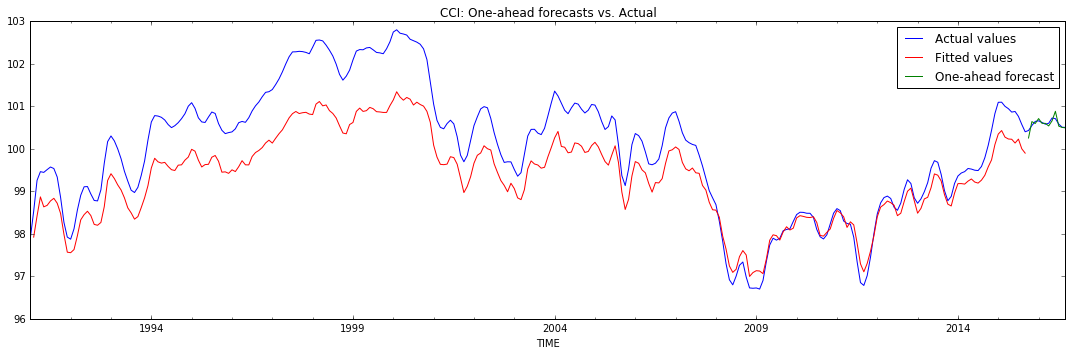

In [66]:
plt.figure(figsize = (15,5))
df.plot(label='Actual values')
pred.plot(color='red', label='Fitted values')
one_ahead = np.concatenate((np.full(len(df)-futureRange,np.nan),allFuture))
one_ahead = pd.Series(one_ahead, index=df.index)
one_ahead.plot(color='green', label='One-ahead forecast')
plt.title('CCI: One-ahead forecasts vs. Actual')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [68]:
'R2 score for Roll-Forward predictions for the last 12 months: {:.3f}'.format(r2_score(df.iloc[-futureRange:].values, allFuture))

'R2 score for Roll-Forward predictions for the last 12 months: -0.043'

The roll-forward expanded model that includes the LDA Topics as exogenous controls does worse than the average CCI scores in predicting the CCI values for in the last year of data. 